In [62]:
# from google.colab import drive
# drive.mount('/content/drive')

In [63]:
import torch
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [64]:
df = pd.read_csv('/content/drive/MyDrive/KLTN/df_final.csv')

In [65]:
display(df.head(5))

,userID,courseId,rating
0,1660673,0,0
1,2021250,0,0
2,293249,0,0
3,3048969,0,0
4,81291,0,2


In [66]:
df = df[df['rating']>=3]
print(len(df))

12017


In [67]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    2984
4    4941
5    4092
Name: rating, dtype: int64

In [68]:
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)

Label Encoding

In [69]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['userID'].values) #chuyển id user, item thành dạng idx (1->n)
train['item_id_idx'] = le_item.fit_transform(train['courseId'].values)

In [70]:
train_user_ids = train['userID'].unique() # lưu lại index
train_item_ids = train['courseId'].unique()

print(len(train_user_ids), len(train_item_ids))

test = test[(test['userID'].isin(train_user_ids)) & (test['courseId'].isin(train_item_ids))]
print(len(test))

8429 431
457


In [71]:
test['user_id_idx'] = le_user.transform(test['userID'].values)
test['item_id_idx'] = le_item.transform(test['courseId'].values)

In [72]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  8429
Number of unique Items :  431


In [73]:
latent_dim = 64
n_layers = 3

In [74]:
def convert_to_sparse_tensor(dok_mtrx):

    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

Metrics

In [75]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index

    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()


Model

In [76]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self): # A_tilda = D^(-1/2)AD^(-1/2)
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32) # R sparse matrix (n_user x n_item)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0 # R[i,j] = 1

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        # convert to list of list format
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        #  A = |0    R|
        #      |R^T  0|
        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten() # D^(-1/2)
        d_inv[np.isinf(d_inv)] = 0.0 # if inf then =0
        d_mat_inv = sp.diags(d_inv)  # to diag matrix
        norm_adj_mat = d_mat_inv.dot(adj_mat) #D^(-1/2) . A
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv) # (D^(-1/2).A).D^(-1/2)

        # Below Code is toconvert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32) # convert form sparse row to COO format
        values = norm_adj_mat_coo.data # save values in matrix COO to arr values
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col)) # index col in COO

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) #((row, col), value)

        return norm_adj_mat_sparse_tensor

    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [77]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)

In [78]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([8860, 64])


BPR Loss

In [79]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):

    reg_loss = (1/2)*(userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

    return loss, reg_loss

Data Loader - Samples users and for each user it sample 1 postive item - which User interacted with in Training Data and 1 negative item - with which User have not interacted

In [80]:
def data_loader(data, batch_size, n_user, n_item):

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_item - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_user)]

    if n_user < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [81]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [82]:
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0001
K = 10

In [86]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)

    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    best_ndcg = -1


    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():

        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg

        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')


    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/30 [00:00<?, ?it/s]

In [87]:
epoch_list = [(i+1) for i in range(EPOCHS)]

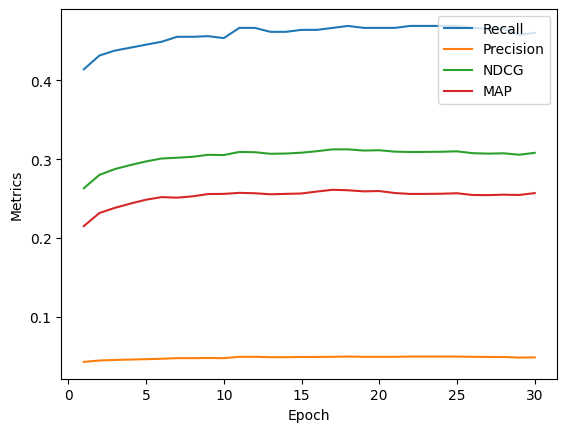

In [88]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

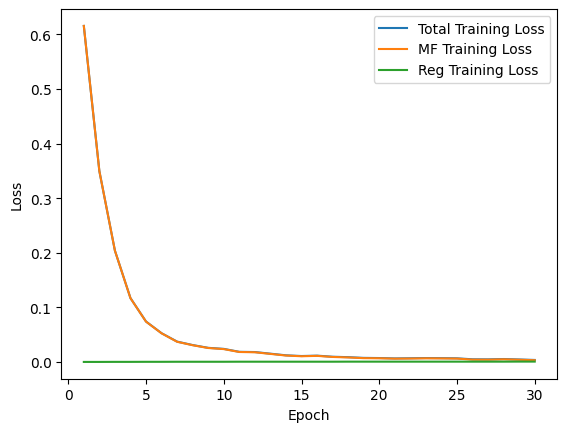

In [89]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [90]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  2.51  seconds
Averge time taken to eval an epoch ->  0.32  seconds


In [27]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.4761
Last Epoch's Test Data Precision ->  0.0501
Last Epoch's Test Data NDCG ->  0.3134
Last Epoch's Test Data MAP ->  0.2587
Last Epoch's Train Data Loss ->  0.0038


user_pos_items = get_user_positive_items(edge_index)

In [28]:
len(pos_items)

1024

In [29]:
user_lists = pd.read_csv('/content/drive/MyDrive/KLTN/users_x.csv')

In [30]:
user_lists

,0
0,1660673
1,2021250
2,293249
3,3048969
4,81291
...,...
347423,6858738
347424,2143320
347425,695993
347426,6986779


In [31]:
user_id = 2021250
rec_k = 10

In [32]:
train

,userID,courseId,rating,user_id_idx,item_id_idx
0,6641408,789,4,4067,333
1,6775501,935,5,6930,403
2,6738207,115,5,5239,47
3,3718990,600,5,1566,255
4,6280729,358,5,3632,149
...,...,...,...,...,...
9608,4292621,115,4,1638,47
9609,4441326,115,5,1973,47
9610,630,105,4,2,43
9611,4443818,115,5,2497,47


In [33]:
def get_user_pos_items(data, n_usr, n_itm):

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [34]:
users, pos_items, neg_items = get_user_pos_items(train, n_users, n_items)

In [35]:
items_emb = torch.load('/content/final_item_Embed.pt')
users_emb = torch.load('/content/final_user_Embed.pt')

In [36]:
np.array(users_emb.cpu().detach().numpy())[3632]

array([ 0.44340855, -0.0587661 ,  0.04129764,  0.06889932,  0.41179776,
       -0.15850353,  0.20585963,  0.25313565,  0.411883  , -0.56914914,
       -0.17516637,  0.21283492,  0.4393077 ,  0.08818631, -0.31698745,
        0.09491549,  0.01948772,  0.00250131, -0.18674985, -0.27418464,
        0.41630447, -0.33678734,  0.15310812,  0.04115444, -0.05257493,
       -0.5190678 ,  0.02373434, -0.27294773,  0.08779638, -0.59546876,
       -0.48858732,  0.05284518,  0.16700377, -0.47576225, -0.28250057,
        0.4257625 ,  0.4095588 , -0.04649176,  0.17783535, -0.29621184,
       -0.5138533 ,  0.06571183, -0.23489334,  0.00601414,  0.08247264,
       -0.08700472,  0.12306429,  0.1524085 ,  0.44409755,  0.21524402,
       -0.2847432 ,  0.01786773,  0.27356666,  0.02727361, -0.12514926,
        0.24913901, -0.12439294, -0.43119758, -0.26814276,  0.28880158,
        0.13721251, -0.47450376, -0.02730941,  0.18772012], dtype=float32)

In [37]:
np.array(items_emb.cpu().detach().numpy())

array([[-0.0772881 ,  0.07131229, -0.15362623, ..., -0.05560026,
         0.21816054,  0.11389119],
       [-0.22610125,  0.23586437, -0.16177237, ..., -0.2089264 ,
         0.21073484,  0.1389483 ],
       [-0.13651526, -0.354672  ,  0.06493125, ..., -0.50919783,
        -0.44028154, -0.21219851],
       ...,
       [-0.7434881 ,  0.8658363 , -0.5316602 , ..., -1.0079561 ,
         0.879925  , -0.7656198 ],
       [ 0.18683256, -0.12691508, -0.1209867 , ...,  0.09453346,
        -0.1856507 , -0.02615502],
       [ 0.41705504,  0.6023803 , -0.72104204, ..., -0.7487579 ,
         0.9078995 , -0.78744256]], dtype=float32)

In [38]:
np.array(users_emb.cpu().detach().numpy())[3632].reshape(1,-1).shape

(1, 64)

In [39]:
user_idx = train['user_id_idx'][train['userID'] == 6280729].unique()

In [40]:
user_idx[0]

3632

In [41]:
e_u = np.array(users_emb.cpu().detach().numpy())[user_idx[0]].reshape(1, -1) # (1,64)

In [42]:
i_u = np.transpose(np.array(items_emb.cpu().detach().numpy())) #(64,431)

In [83]:
e_u @ i_u

array([[-3.32449168e-01, -9.18804765e-01,  2.74587131e+00,
        -1.23584723e+00,  1.62612587e-01, -1.02316976e+00,
        -5.69045424e-01, -2.64620066e-01,  2.66102314e-01,
        -1.48501825e+00, -3.87626499e-01,  9.79530662e-02,
         4.56213474e-01,  2.78220558e+00, -2.24006057e-01,
         2.57526875e-01,  1.02460277e+00, -4.20962155e-01,
         5.82269609e-01,  4.61245865e-01,  2.23854274e-01,
         7.75956929e-01, -2.87210703e+00, -5.07783890e-01,
        -2.68425465e-01,  1.20207143e+00,  3.67222279e-02,
         3.12743753e-01,  1.09969795e+00,  4.48260307e-01,
         1.24458253e+00, -4.50654775e-02, -6.67183846e-02,
        -2.67942905e+00, -4.61410433e-01, -5.00008225e-01,
        -2.82218218e+00, -5.65619469e-01, -9.09708083e-01,
         3.65184367e-01, -4.94010359e-01,  1.59628725e+00,
        -9.25196290e-01,  2.10153985e+00,  3.27379555e-02,
         1.42582357e+00,  2.94156194e-01, -9.49732208e+00,
         5.57454157e+00,  3.43145579e-02, -2.05850267e+0

In [84]:
scores = torch.tensor(e_u @ i_u)

In [45]:
exclude_items = train['item_id_idx'][train['user_id_idx'] == 6280729]
scores[exclude_items] = -(1 << 10)

In [46]:
values, indices = torch.topk(scores, k=10)

In [47]:
values

tensor([[6.3331, 5.8151, 5.5997, 5.5745, 5.2825, 4.8603, 4.2590, 4.2039, 4.0254,
         4.0167]])

In [48]:
indices

tensor([[212, 174, 325,  48, 112, 369, 274, 220, 104, 198]])

In [49]:
indices.cpu().numpy()

array([[212, 174, 325,  48, 112, 369, 274, 220, 104, 198]])

In [50]:
idx = [x for x in indices.cpu().numpy()[0]]

In [51]:
course_id = []
for x in idx:
  course_id.append(train['courseId'][train['item_id_idx'] == x].unique()[0])
course_id

[504, 415, 771, 116, 272, 870, 643, 516, 249, 474]

In [52]:
course_map = pd.read_csv('/content/drive/MyDrive/KLTN/map_course.csv')

In [53]:
course_map.loc[course_id].values

array([[504, 'course-v1:TsinghuaX+00612643X+2017_T1'],
       [415, 'course-v1:SEU+00034237+sp'],
       [771, 'course-v1:TsinghuaX+00670122X+2017_T1'],
       [116, 'course-v1:HIT+13SC20301820+sp'],
       [272, 'course-v1:TsinghuaX+00690863X+2017_T1'],
       [870, 'course-v1:TsinghuaX+00804723X+2017_T1'],
       [643, 'course-v1:TsinghuaX+80000901X_1+2017_T1'],
       [516, 'course-v1:TsinghuaX+00310222X+sp'],
       [249, 'course-v1:TsinghuaX+00740123_X+sp'],
       [474, 'course-v1:SEU+00034237_p2+sp']], dtype=object)

In [54]:
np.transpose(np.array(items_emb.cpu().detach().numpy())).shape

(64, 431)

In [55]:
len(train['user_id_idx'].unique())

8429

In [56]:
train[train['user_id_idx'] == 3632]

,userID,courseId,rating,user_id_idx,item_id_idx
4,6280729,358,5,3632,149
763,6280729,236,5,3632,96
1267,6280729,249,5,3632,104
1313,6280729,566,5,3632,240
2237,6280729,313,4,3632,130
2423,6280729,387,5,3632,162
2688,6280729,948,3,3632,413
2902,6280729,214,3,3632,85
3229,6280729,964,3,3632,420
3558,6280729,902,3,3632,383


In [57]:
def make_predictions(user_id):
    if len(train['user_id_idx'][train['userID'] == user_id].unique()) != 0:
      user_idx = train['user_id_idx'][train['userID'] == user_id].unique()[-1]
      e_u = np.array(users_emb.cpu().detach().numpy())[user_idx].reshape(1, -1) # (1,64) # detach if error occured
      i_u = np.transpose(np.array(items_emb.cpu().detach().numpy()))
      scores = torch.tensor(e_u @ i_u)

      exclude_items = train['item_id_idx'][train['user_id_idx'] == user_id]
      scores[exclude_items] = -(1 << 10)
      values, indices = torch.topk(scores, k=10)
      return values, indices

In [58]:
v, indices = make_predictions(6280729)

In [59]:
idx = [x for x in indices.cpu().numpy()[0]]

course_id = []
for x in idx:
  course_id.append(train['courseId'][train['item_id_idx'] == x].unique()[0])

rcm = course_map.loc[course_id]

In [60]:
rcm = rcm.drop(columns=['Unnamed: 0'])

In [85]:
print('top 10 recommend courses for user ', 6280729 ,'are: \n', rcm['0'])

top 10 recommend courses for user  6280729 are: 
 504      course-v1:TsinghuaX+00612643X+2017_T1
415                  course-v1:SEU+00034237+sp
771      course-v1:TsinghuaX+00670122X+2017_T1
116              course-v1:HIT+13SC20301820+sp
272      course-v1:TsinghuaX+00690863X+2017_T1
870      course-v1:TsinghuaX+00804723X+2017_T1
643    course-v1:TsinghuaX+80000901X_1+2017_T1
516           course-v1:TsinghuaX+00310222X+sp
249          course-v1:TsinghuaX+00740123_X+sp
474               course-v1:SEU+00034237_p2+sp
Name: 0, dtype: object
